## Introduction

In this notebook we will train a baseline lightgbm regression model using the ancillary data (satellite data, soil data, climate data etc.) for each image and embeddings from the images generated from an EfficientVIT model to predict the 6 plant properties. The EfficientVit model was trained on the ImageNet-1K dataset.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score 

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

import joblib
from pathlib import Path

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## Loading the data

In [2]:
path = Path('/kaggle/input/planttraits2024/')
train = pd.read_csv(path / 'train.csv', index_col=['id'])
train.head()

,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
id,,,,,,,,,,,,,,,,,,,,,
192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,145,...,0.117484,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054
195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,143,...,0.389315,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477
196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,126,...,8.552908,0.395241,2.343153,1130.096731,NaN,NaN,NaN,NaN,NaN,NaN
195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,131,...,1.083629,0.154200,1.155308,1042.686546,0.011692,2.818356,0.110673,0.011334,0.229224,141.857187
195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,138,...,0.657585,10.919966,2.246226,2386.467180,0.006157,1.128000,0.026996,0.553815,0.107092,87.146899


In [3]:
print(f'Number of observations in training data: {train.shape[0]}')

Number of observations in training data: 55489


In [4]:
targets = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']

In [5]:
# last 12 columns correspond to the targets
train.columns[-12:]

Index(['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean',
       'X4_sd', 'X11_sd', 'X18_sd', 'X26_sd', 'X50_sd', 'X3112_sd'],
      dtype='object')

## Exploratory Data Analysis

### Missing values

We first check for missing entries. It turns out all the `sd` columns have about 30% of the entries missing. In this version, we will focus only finding the mean. 

In [6]:
# check for missing values
def filter_greater_than(s:pd.Series, threshold:float):
    return s[s > threshold]


missing_perc = (
    (train.isna().sum() / train.shape[0] * 100) 
    .pipe(filter_greater_than, threshold=0.)
    .sort_values(ascending=False)
)
missing_perc

X4_sd       29.44908
X11_sd      29.44908
X18_sd      29.44908
X26_sd      29.44908
X50_sd      29.44908
X3112_sd    29.44908
dtype: float64

In [7]:
target_cols = [f'{col}_mean' for col in targets]
tabular = train.iloc[:,:-12]
Y = train[target_cols]

### Target distributions

There seem to be rather large outliers in the targets 

In [8]:
target_cols = [f'{col}_mean' for col in targets]
train[target_cols].describe(percentiles=[0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.98])

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,55489.000000,5.548900e+04,5.548900e+04,55489.000000,5.548900e+04,5.548900e+04
mean,0.522575,1.325267e+02,1.969902e+04,13.528574,3.459399e+03,3.975552e+05
std,0.174853,1.278220e+04,2.309747e+06,1356.480785,2.471919e+05,9.152463e+07
min,-2.431157,6.780000e-05,2.330000e-08,0.000097,5.500000e-07,7.690000e-08
2%,0.260990,3.626910e+00,5.492267e-02,0.595160,1.751672e-02,1.725723e+01
2.5%,0.272712,3.973504e+00,6.405945e-02,0.634611,2.091185e-02,2.107747e+01
5%,0.304198,4.914833e+00,1.020808e-01,0.774153,4.672269e-02,4.241935e+01
10%,0.338505,6.466692e+00,1.627364e-01,0.923581,1.185212e-01,8.977614e+01
25%,0.410995,1.063987e+01,3.102831e-01,1.173489,5.613414e-01,2.552815e+02
50%,0.509009,1.511232e+01,7.156651e-01,1.480060,2.519985e+00,7.244318e+02


We will remove rows where any of the targets is less than 0 or greater than the 98th quantile.

In [9]:
lower_quantiles = 0
upper_quantiles = Y.quantile(0.98)

retained_flag = ((Y >= lower_quantiles) & (Y < upper_quantiles)).all(axis=1)
tabular = tabular[retained_flag]
Y = Y[retained_flag]

print(f'Number of observations removed: {retained_flag.shape[0] - retained_flag.sum()}')

Number of observations removed: 5691


Even after the outliers are removed, some of the targets still have large skew in their distribution. Since the metric is $R^2$ on the actual targets, we will not apply any transformation on the targets to correct for the skewness

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

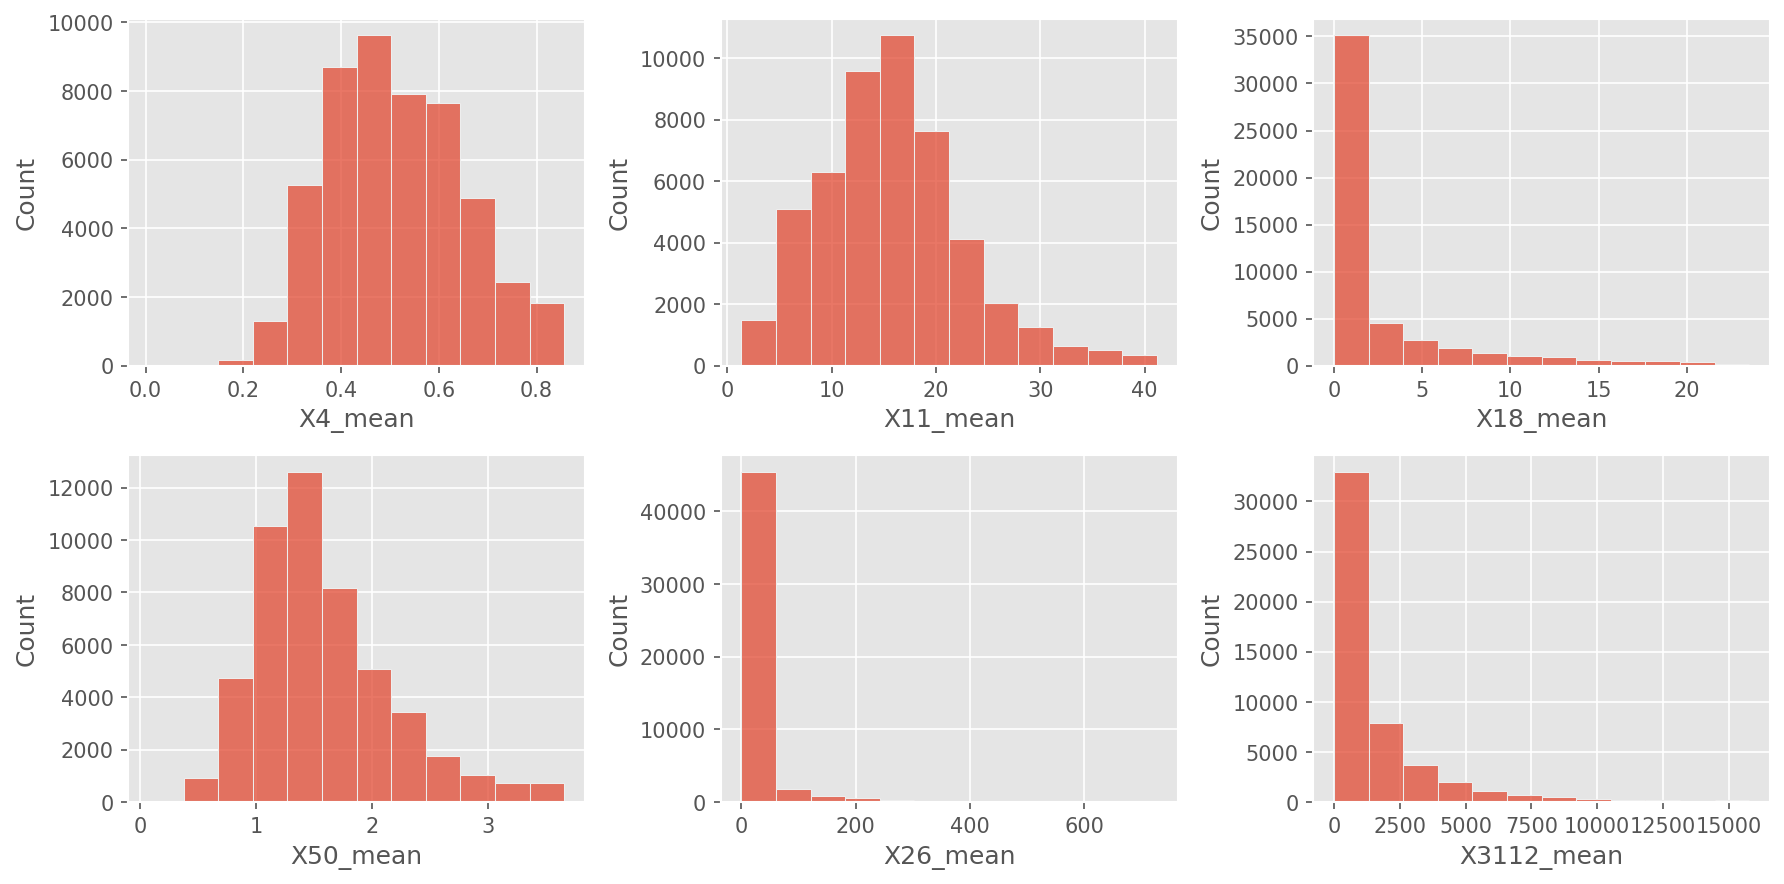

In [10]:
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i, column in enumerate(Y.columns):
    row_idx, col_idx = divmod(i, n_cols)
    _ = sns.histplot(data=Y, x=column, ax=axs[row_idx, col_idx], bins=12)

fig.tight_layout()

From the correlation heatmap below, we can see that some of the outputs are correlated. There may be an advantage in jointly modeling the targets. Note that we compute the Spearman rank correlation, which measures the strength of a monotonic relationship between two variables.

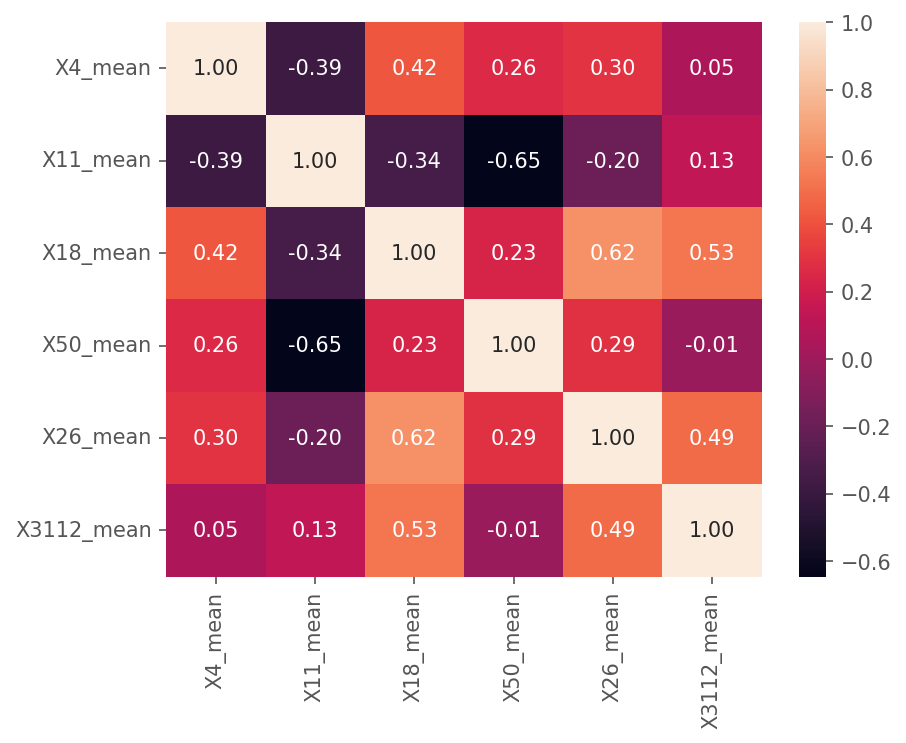

In [11]:
spearman_corr = Y.corr(method='spearman')
_ = sns.heatmap(spearman_corr, annot=True, fmt='.2f')

### Correlation analysis - hierarchical clustering

We now compute the Spearman rank correlations between pairs of the features, and drop ones which are highly correlated with each other. Since there are many columns, we will perform hierarchical clustering to cluster the features.

Hierarchical clustering arranges the data (in our case, features) using a dissimilarity (or distance) matrix. In our case, we compute the dissimilarity between two features $x_i$ and $x_j$  as
$$
    \large
    d(x_i,x_j) = 1 - |r(x_i, x_j)|,
$$
where $r(x_i, x_j)$ is the Spearman rank correlation between $x_1$ and $x_2$. The Spearman rank measures the degrees of monotonic dependence between two features. Values closer to +1 or -1 indicate a monotonically increasing or decreasing relationships respectively. So, the dissimilarity between two features will be close to 0 if they are nearly monotonic fuctions of each other. 

In [12]:
# construct correlation matrix
corr_matrix = tabular.corr(method='spearman')

# hierarchical cluster based on the correlations
dissimilarity = 1 - abs(corr_matrix.values)

After computing the dissimilaity matrix, we then perform hierarchical clustering on the features. We can then visualize the hierarchy of relationships using a dendrogram plot, which displays a tree-like structure, with branches that represent the merging of similar features at different levels of dissimilarity. The leaves of the dendograms are the features.

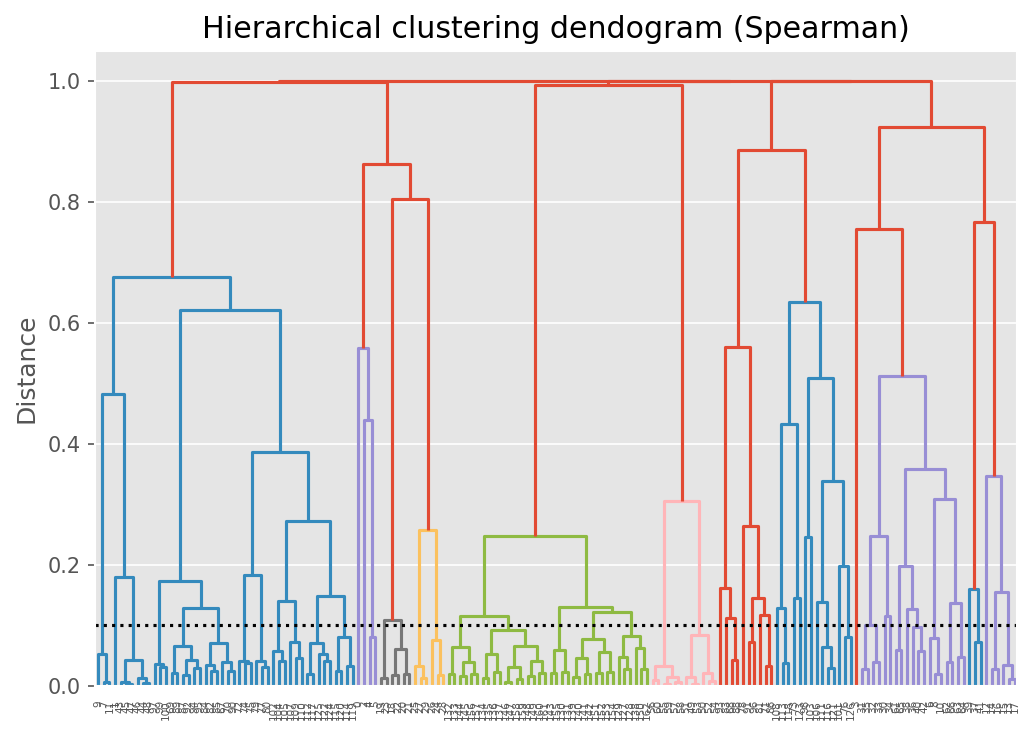

In [13]:
linkage_matrix = hierarchy.linkage(squareform(dissimilarity), method='complete')

# plot the dendogram
fig,ax = plt.subplots(1,1,figsize=(7,5))
dendogram = hierarchy.dendrogram(
    linkage_matrix, ax=ax, 
#     labels=corr_matrix.columns.tolist(),
)
# _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set_ylabel('Distance')
_ = ax.set_title('Hierarchical clustering dendogram (Spearman)')
_ = ax.axhline(0.1, 0, 1, linestyle='dotted', color='k')
#_ = ax.axhline(0.15, 0, 1, linestyle='dotted', color='k')
_ = ax.grid(False, axis='x')
fig.tight_layout()

We will now generate the cluster labels for each feature. The number of clusters will depend on the distance we use as threshold. For smaller distance thresholds, more clusters will be formed. Here, we use a distance threshold of 0.15. 

In [14]:
# get the cluster labels
threshold = 0.15
cluster_labels = hierarchy.fcluster(linkage_matrix, threshold, criterion='distance')
n_clusters = np.unique(cluster_labels).shape[0]
print(f'Number of clusters: {n_clusters}\n')

Number of clusters: 42



In [15]:
cluster_features = {}

# show features within each cluster
for label in range(1, n_clusters + 1):
    #print(f'Cluster {label}')
    
    leaves_in_cluster = cluster_labels == label
    cluster_features[label] = corr_matrix.columns[leaves_in_cluster].tolist()
    #print(cluster_features[label])
    #print()
    
with open('feature_clusters.json', 'w') as f:
    json.dump(cluster_features, f)

Finally, we will select only one feature from each cluster. 

In [16]:
final_features = []
for cols_in_cluster in cluster_features.values():
    final_features.append(cols_in_cluster[0])
    
tabular = tabular[final_features]

## Concatenating image embeddings

In [17]:
emb_path = Path('/kaggle/input/planttraits-efficientvit-embeddings/')
train_embds = pd.read_parquet(emb_path / 'train_embeddings.parquet').set_index('id')

print(f'Shape of embeddings: {train_embds.shape}')

Shape of embeddings: (55489, 128)


In [18]:
train_embds = train_embds[retained_flag]

X = train_embds.join(tabular)
X.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,SOIL_soc_0.5cm_mean_0.01_deg,SOIL_ocd_0.5cm_mean_0.01_deg,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_soc_100.200cm_mean_0.01_deg,WORLDCLIM_BIO15_precipitation_seasonality,SOIL_ocd_100.200cm_mean_0.01_deg,SOIL_ocd_30.60cm_mean_0.01_deg,SOIL_cec_15.30cm_mean_0.01_deg,SOIL_cec_100.200cm_mean_0.01_deg,SOIL_cec_0.5cm_mean_0.01_deg
id,,,,,,,,,,,,,,,,,,,,,
192027691,-0.240760,0.369821,0.356010,1.513708,-0.566686,-0.376986,-0.429451,-1.219931,-0.259638,-0.324570,...,312,268,125,49,72.256844,38,91,221,210,228
195542235,0.386144,-0.022007,0.032580,-0.949619,0.659542,-0.708716,0.605830,-0.759013,1.756518,-0.470889,...,52,83,124,49,38.220940,108,59,149,139,145
196639184,0.441033,0.742968,-0.225605,1.801558,-1.797607,-0.734186,-0.957941,-0.446184,-0.223313,0.312134,...,783,577,107,288,17.873655,206,238,252,254,283
195728812,0.954137,0.526278,1.113327,1.362657,0.909216,-0.618112,-0.154356,0.309024,0.201940,0.064761,...,473,450,120,62,45.009758,68,127,223,220,234
195251545,0.147984,1.205214,-0.004871,1.414045,-0.294477,-0.915839,0.082562,-2.348808,-0.220496,-0.282386,...,737,577,91,178,38.230709,66,170,352,325,381


## Tuning hyperparameters via Optuna

We will tune hyperparameters separately for each output.

In [19]:
def optuna_objective(trial, output_idx):
    config = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 5e-3, 0.5,log=True),
        'num_leaves': trial.suggest_int('num_leaves', 4, 256, log=True),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 1),
        'colsample_bynode': trial.suggest_float("colsample_bynode", 0.1, 1),
        'subsample': trial.suggest_float("subsample", 0.25, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 100,log=True), # l1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda',1e-8, 100, log=True), # l2 regularization
        'min_split_gain': trial.suggest_float('min_split_gain',1e-8, 100, log=True), # gamma in xgboost,
        #'min_child_weight': trial.suggest_float('min_child_weight', 1, 2000, log=True)
    }
    
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    cv_r2 = []
    for i, (train_index, test_index) in enumerate(cv.split(tabular, Y)):
        model = LGBMRegressor(
            max_depth=12, 
            device="gpu", 
            verbose=-1,
            **config
        ).fit(
            X.iloc[train_index, :], 
            Y.iloc[train_index, output_idx].values,
        )
        
        y_test_pred = model.predict(X.iloc[test_index, :])
        
        cv_r2.append(
            r2_score(Y.iloc[test_index, output_idx].values, y_test_pred)
        )
        
    return np.mean(cv_r2, axis=0)



In [20]:
from functools import partial

OPTUNA_RES_DIR = Path('optuna_res')
if not os.path.exists(OPTUNA_RES_DIR):
    os.makedirs(OPTUNA_RES_DIR)
    
BEST_PARAMS = {}
BEST_CV_R2 = {}


for output_idx in range(6):
    print(f'*********** Optimizing CV R^2 for {targets[output_idx]} ***********')
    study = optuna.create_study(
        directions=['maximize'], 
        sampler=optuna.samplers.TPESampler(n_startup_trials=10, seed=0),
        study_name=f'lightgbm_{targets[output_idx]}'
    )

    # run optuna for a maxmimum of 50 trials or 30 min wall clock time
    study.optimize(partial(optuna_objective, output_idx=output_idx), n_trials=50, timeout= 1800) 
    
    # store the best parameters and value
    BEST_PARAMS[targets[output_idx]] = study.best_params
    BEST_CV_R2[targets[output_idx]] = study.best_value
    
    # save the runs as csv
    results = study.trials_dataframe(attrs=('number','value', 'duration', 'params', 'user_attrs'))
    results = results.rename(columns={'value':'R2'})
    results['duration'] = results['duration']/np.timedelta64(1, 's')
    results = results.sort_values(by='R2',ascending=False)
    results.to_csv(OPTUNA_RES_DIR / f'cv_r2_{targets[output_idx]}.csv',index=False)
    
    # save the study object
    _ = joblib.dump(study, OPTUNA_RES_DIR / f'lightgbm_{targets[output_idx]}.pkl')
    print()


[I 2024-06-01 19:56:26,500] A new study created in memory with name: lightgbm_X4


*********** Optimizing CV R^2 for X4 ***********


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
[I 2024-06-01 19:56:37,656] Trial 0 finished with value: 0.04703802531190693 and parameters: {'n_estimators': 258, 'learning_rate': 0.1346941509642705, 'num_leaves': 47, 'colsample_bytree': 0.5903948646972071, 'colsample_bynode': 0.4812893194050143, 'subsample': 0.7344205847999921, 'reg_alpha': 0.000237614


*********** Optimizing CV R^2 for X11 ***********


[I 2024-06-01 20:29:50,723] Trial 0 finished with value: 0.27447113510627885 and parameters: {'n_estimators': 258, 'learning_rate': 0.1346941509642705, 'num_leaves': 47, 'colsample_bytree': 0.5903948646972071, 'colsample_bynode': 0.4812893194050143, 'subsample': 0.7344205847999921, 'reg_alpha': 0.00023761404778025518, 'reg_lambda': 8.274276086161453, 'min_split_gain': 43.31393146405955}. Best is trial 0 with value: 0.27447113510627885.
[I 2024-06-01 20:30:07,215] Trial 1 finished with value: 0.25906009887335923 and parameters: {'n_estimators': 157, 'learning_rate': 0.1916108425246393, 'num_leaves': 34, 'colsample_bytree': 0.6112401049845391, 'colsample_bynode': 0.933036974463395, 'subsample': 0.30327704364841523, 'reg_alpha': 7.435205853060173e-08, 'reg_lambda': 1.5928833561691773e-08, 'min_split_gain': 2.1193293640885202}. Best is trial 0 with value: 0.27447113510627885.
[I 2024-06-01 20:33:43,812] Trial 2 finished with value: 0.1992768379510706 and parameters: {'n_estimators': 514, '


*********** Optimizing CV R^2 for X18 ***********


[I 2024-06-01 21:00:31,303] Trial 0 finished with value: 0.41724098266757387 and parameters: {'n_estimators': 258, 'learning_rate': 0.1346941509642705, 'num_leaves': 47, 'colsample_bytree': 0.5903948646972071, 'colsample_bynode': 0.4812893194050143, 'subsample': 0.7344205847999921, 'reg_alpha': 0.00023761404778025518, 'reg_lambda': 8.274276086161453, 'min_split_gain': 43.31393146405955}. Best is trial 0 with value: 0.41724098266757387.
[I 2024-06-01 21:00:46,884] Trial 1 finished with value: 0.4089392693204149 and parameters: {'n_estimators': 157, 'learning_rate': 0.1916108425246393, 'num_leaves': 34, 'colsample_bytree': 0.6112401049845391, 'colsample_bynode': 0.933036974463395, 'subsample': 0.30327704364841523, 'reg_alpha': 7.435205853060173e-08, 'reg_lambda': 1.5928833561691773e-08, 'min_split_gain': 2.1193293640885202}. Best is trial 0 with value: 0.41724098266757387.
[I 2024-06-01 21:04:28,206] Trial 2 finished with value: 0.3681850212555646 and parameters: {'n_estimators': 514, 'l


*********** Optimizing CV R^2 for X50 ***********


[I 2024-06-01 21:30:38,260] Trial 0 finished with value: 0.08939475847779513 and parameters: {'n_estimators': 258, 'learning_rate': 0.1346941509642705, 'num_leaves': 47, 'colsample_bytree': 0.5903948646972071, 'colsample_bynode': 0.4812893194050143, 'subsample': 0.7344205847999921, 'reg_alpha': 0.00023761404778025518, 'reg_lambda': 8.274276086161453, 'min_split_gain': 43.31393146405955}. Best is trial 0 with value: 0.08939475847779513.
[I 2024-06-01 21:30:45,785] Trial 1 finished with value: 0.1577612572631265 and parameters: {'n_estimators': 157, 'learning_rate': 0.1916108425246393, 'num_leaves': 34, 'colsample_bytree': 0.6112401049845391, 'colsample_bynode': 0.933036974463395, 'subsample': 0.30327704364841523, 'reg_alpha': 7.435205853060173e-08, 'reg_lambda': 1.5928833561691773e-08, 'min_split_gain': 2.1193293640885202}. Best is trial 1 with value: 0.1577612572631265.
[I 2024-06-01 21:34:25,868] Trial 2 finished with value: 0.09205754082840696 and parameters: {'n_estimators': 514, 'l


*********** Optimizing CV R^2 for X26 ***********


[I 2024-06-01 22:03:36,136] Trial 0 finished with value: 0.17965170086282642 and parameters: {'n_estimators': 258, 'learning_rate': 0.1346941509642705, 'num_leaves': 47, 'colsample_bytree': 0.5903948646972071, 'colsample_bynode': 0.4812893194050143, 'subsample': 0.7344205847999921, 'reg_alpha': 0.00023761404778025518, 'reg_lambda': 8.274276086161453, 'min_split_gain': 43.31393146405955}. Best is trial 0 with value: 0.17965170086282642.
[I 2024-06-01 22:03:51,321] Trial 1 finished with value: 0.14367032299760116 and parameters: {'n_estimators': 157, 'learning_rate': 0.1916108425246393, 'num_leaves': 34, 'colsample_bytree': 0.6112401049845391, 'colsample_bynode': 0.933036974463395, 'subsample': 0.30327704364841523, 'reg_alpha': 7.435205853060173e-08, 'reg_lambda': 1.5928833561691773e-08, 'min_split_gain': 2.1193293640885202}. Best is trial 0 with value: 0.17965170086282642.
[I 2024-06-01 22:07:29,638] Trial 2 finished with value: 0.09470381669878052 and parameters: {'n_estimators': 514, 


*********** Optimizing CV R^2 for X3112 ***********


[I 2024-06-01 22:35:07,670] Trial 0 finished with value: 0.30663734903684303 and parameters: {'n_estimators': 258, 'learning_rate': 0.1346941509642705, 'num_leaves': 47, 'colsample_bytree': 0.5903948646972071, 'colsample_bynode': 0.4812893194050143, 'subsample': 0.7344205847999921, 'reg_alpha': 0.00023761404778025518, 'reg_lambda': 8.274276086161453, 'min_split_gain': 43.31393146405955}. Best is trial 0 with value: 0.30663734903684303.
[I 2024-06-01 22:35:22,624] Trial 1 finished with value: 0.2897026292237393 and parameters: {'n_estimators': 157, 'learning_rate': 0.1916108425246393, 'num_leaves': 34, 'colsample_bytree': 0.6112401049845391, 'colsample_bynode': 0.933036974463395, 'subsample': 0.30327704364841523, 'reg_alpha': 7.435205853060173e-08, 'reg_lambda': 1.5928833561691773e-08, 'min_split_gain': 2.1193293640885202}. Best is trial 0 with value: 0.30663734903684303.
[I 2024-06-01 22:39:00,308] Trial 2 finished with value: 0.23207577839683963 and parameters: {'n_estimators': 514, '

The best hyperparameters found so far are as follows:

In [21]:
BEST_PARAMS

{'X4': {'n_estimators': 732,
  'learning_rate': 0.018946528247534143,
  'num_leaves': 239,
  'colsample_bytree': 0.5240978724074181,
  'colsample_bynode': 0.6667554136169002,
  'subsample': 0.4169827770737486,
  'reg_alpha': 0.5624412233164827,
  'reg_lambda': 0.0003610137807743432,
  'min_split_gain': 1.057198393806282e-06},
 'X11': {'n_estimators': 677,
  'learning_rate': 0.022602015263856606,
  'num_leaves': 141,
  'colsample_bytree': 0.9911897559546625,
  'colsample_bynode': 0.23157719568795526,
  'subsample': 0.9049267300088708,
  'reg_alpha': 99.93392585903727,
  'reg_lambda': 0.8083980487639165,
  'min_split_gain': 2.7308736431101315e-05},
 'X18': {'n_estimators': 575,
  'learning_rate': 0.02826625969291468,
  'num_leaves': 114,
  'colsample_bytree': 0.7354000894826939,
  'colsample_bynode': 0.986059228301836,
  'subsample': 0.9829738929728645,
  'reg_alpha': 54.65124914888526,
  'reg_lambda': 0.00020708451740732742,
  'min_split_gain': 0.22542067410676705},
 'X50': {'n_estimato

In [22]:
print(f'Best 5-fold CV R^2: {np.mean([r2 for r2 in BEST_CV_R2.values()]):.4f}')

Best 5-fold CV R^2: 0.2978


## Individual output $R^2$

In [23]:
pd.Series(BEST_CV_R2)

X4       0.297252
X11      0.296487
X18      0.452777
X50      0.200580
X26      0.209418
X3112    0.329995
dtype: float64

## Final models

In [24]:
models_dict = {}
Y_train_pred = Y.copy()

for i in range(6):
    models_dict[targets[i]] = LGBMRegressor(
        max_depth=12, device='gpu', verbose=-1,
        **BEST_PARAMS[targets[i]]
    ).fit(
        X, Y.iloc[:, i].values
    )
    
    Y_train_pred.iloc[:, i] = models_dict[targets[i]].predict(X)

In [25]:
training_r2 = r2_score(Y, Y_train_pred)
print(f'Training R^2: {training_r2:.4f}')

Training R^2: 0.7733


## Predictions on Test Data

In [26]:
tabular_test = pd.read_csv(path / 'test.csv', index_col=['id'])[final_features]
test_embds = pd.read_parquet(emb_path / 'test_embeddings.parquet').set_index('id')
test = test_embds.join(tabular_test)

In [27]:
test_preds = []
for i in range(6):
    test_preds.append(
        np.maximum(models_dict[targets[i]].predict(test), 0)
    )

test_preds = np.column_stack(test_preds)

In [28]:
submission = pd.DataFrame(
    test_preds,
    columns=targets,
    index=test.index
).reset_index()


submission.to_csv('submission.csv', index=False)

In [29]:
submission.head()

,id,X4,X11,X18,X50,X26,X3112
0,201238668,0.633491,10.536669,1.953159,1.509969,11.293972,548.763584
1,202310319,0.445514,17.887620,0.648696,1.445659,6.392381,789.250338
2,202604412,0.519351,14.462702,1.273922,1.750834,20.596059,901.745989
3,201353439,0.482648,19.641907,0.353283,1.326921,5.758508,990.776195
4,195351745,0.502092,11.753428,0.079809,1.448307,0.000000,246.919885
